In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from opdynamics.model import Model

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")
from matplotlib.ticker import MaxNLocator
from opdynamics.utils.reading_tools import (parse_experiment_params,
                                            make_tuple,
                                            count_experiment_runs,
                                            get_runs_paths)
from opdynamics.utils.results_tools import get_experiment_mean_data
from opdynamics.utils.plotting.formatting import (classical_structure,
                                                  format_text)
from opdynamics.utils.plotting.plotting import heat_plot

In [27]:
small_model = Model(
        graph_type = "barabasi",
        network_size = 500,
        memory_size = 256,
        code_length = 5,
        kappa = 15,
        lambd = 0,
        alpha = 0,
        omega = 0,
        gamma = 0,
        preferential_attachment = 2,
        polarization_grouping_type = 0,
        distribution = "binomial",
    )

big_model = Model(
        graph_type = "barabasi",
        network_size = 3000,
        memory_size = 256,
        code_length = 5,
        kappa = 15,
        lambd = 0,
        alpha = 0,
        omega = 0,
        gamma = 0,
        preferential_attachment = 2,
        polarization_grouping_type = 0,
        distribution = "binomial",
    )

In [44]:
def calculate_degree_ratios(G):
    degree_ratios = []

    for node in G.nodes():
        node_degree = G.degree[node]
        for neighbor in G.neighbors(node):
            neighbor_degree = G.degree[neighbor]

            if neighbor_degree != 0:
                ratio = node_degree / neighbor_degree
                degree_ratios.append(ratio)
            else:
                print(f"Warning: Neighbor {neighbor} of node {node} has a degree of 0. Skipping ratio.")

    return degree_ratios

def acceptance_probability(G, u: int, v: int, gamma: float) -> float:
    # Ensure nodes exist in the graph
    if u not in G or v not in G:
        raise ValueError(f"Node {u} or {v} not found in the graph.")

    degree_u_gamma = G.degree[u]**gamma

    neighbor_degrees_gamma = [G.degree[w]**gamma for w in G.neighbors(u)]

    all_sigmas = {degree_u_gamma}.union(neighbor_degrees_gamma)

    max_sigma = max(all_sigmas)

    if max_sigma == 0:
        return 0.0

    sigma_ratio = (G.degree[v]**gamma) / max_sigma

    return sigma_ratio


def calculate_all_sigma_ratios(G, gamma: float = 0.5) -> list[float]:
    sigma_ratios_list = []
    nodes = list(G.nodes()) # Get all nodes in the graph

    for u in nodes:
        for v in nodes:
            try:
                ratio = acceptance_probability(G, u, v, gamma)
                sigma_ratios_list.append(ratio)
            except ValueError as e:
                print(f"Error calculating ratio for ({u}, {v}): {e}")
            except Exception as e:
                print(f"An unexpected error occurred for ({u}, {v}): {e}")
    return sigma_ratios_list

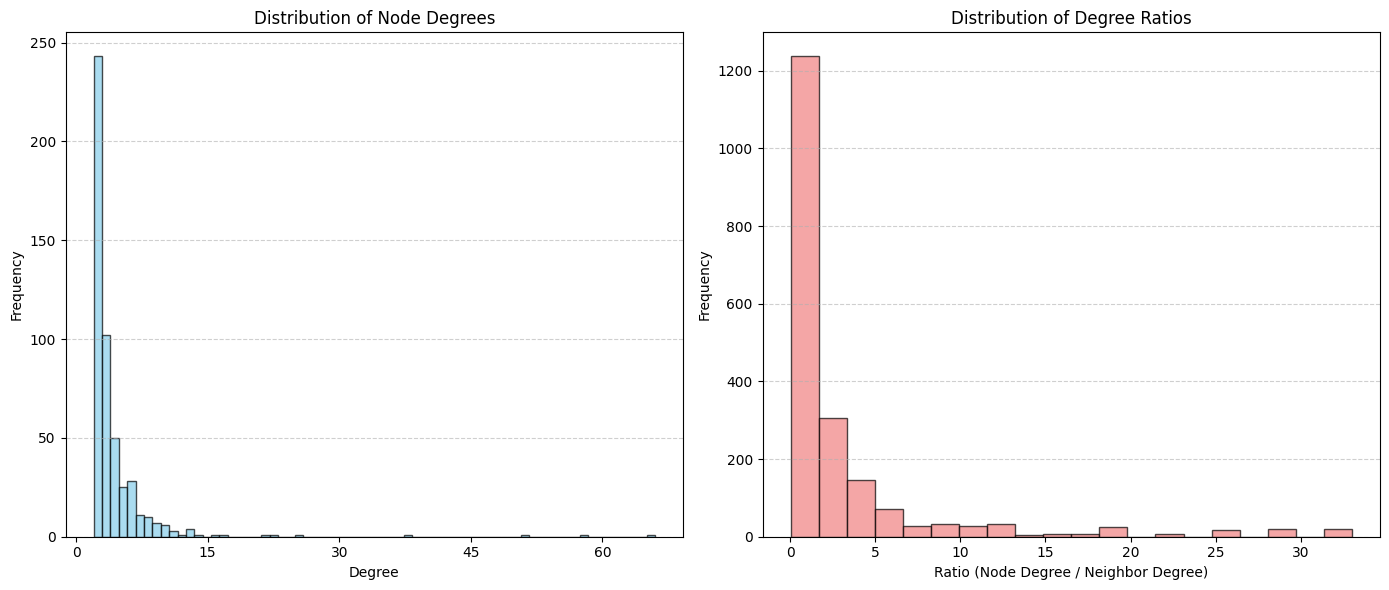

In [32]:
degrees = list(dict(small_model.G.degree).values())
ratios = calculate_degree_ratios(small_model.G)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Adjusted figsize for better display

# Plotting the distribution of degrees
axes[0].hist(degrees, bins=max(degrees) + 1 if degrees else 10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Node Degrees')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticks(range(max(degrees) + 1) if degrees else []) # Ensure integer ticks if possible
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

# Plotting the distribution of ratios
# Adjust bins for ratios, consider using a dynamic range or fixed number of bins
if ratios:
    num_bins = min(20, int(len(ratios)**(1/3) * 2)) # Simple heuristic for bin count
    axes[1].hist(ratios, bins=num_bins, color='lightcoral', edgecolor='black', alpha=0.7)
else:
    # If ratios list is empty, just show an empty plot for this subplot
    axes[1].text(0.5, 0.5, "No ratios to display", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

axes[1].set_title('Distribution of Degree Ratios')
axes[1].set_xlabel('Ratio (Node Degree / Neighbor Degree)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

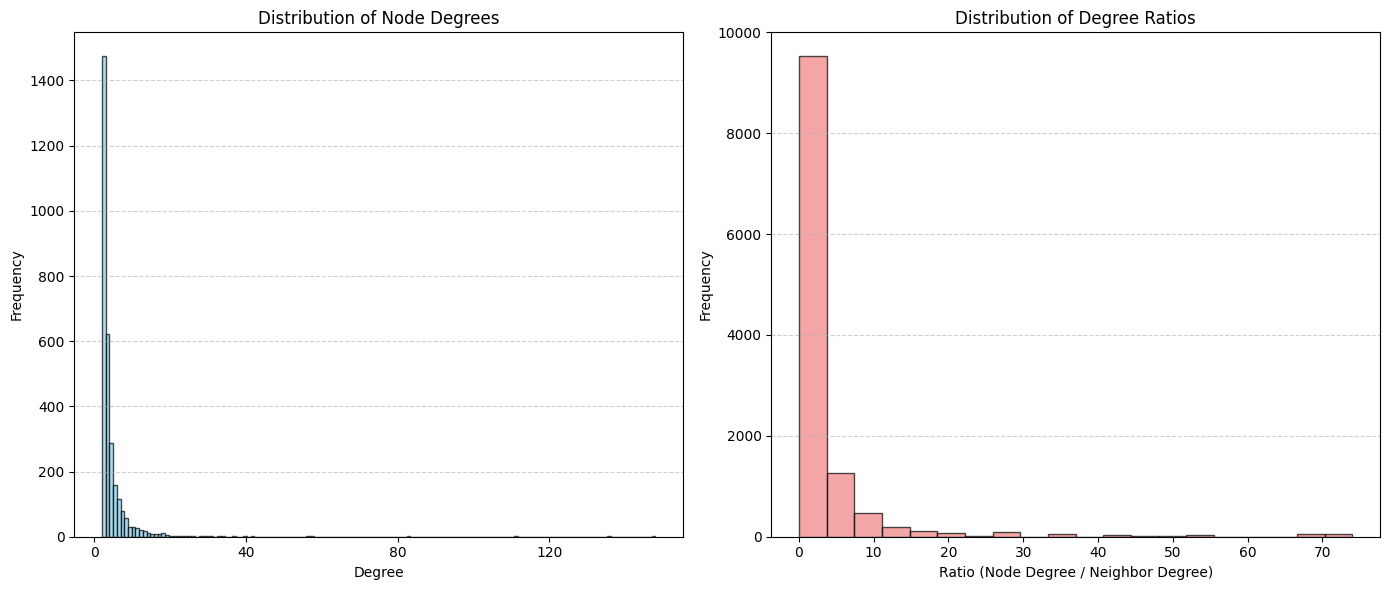

In [33]:
degrees = list(dict(big_model.G.degree).values())
ratios = calculate_degree_ratios(big_model.G)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Adjusted figsize for better display

# Plotting the distribution of degrees
axes[0].hist(degrees, bins=max(degrees) + 1 if degrees else 10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Node Degrees')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticks(range(max(degrees) + 1) if degrees else []) # Ensure integer ticks if possible
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

# Plotting the distribution of ratios
# Adjust bins for ratios, consider using a dynamic range or fixed number of bins
if ratios:
    num_bins = min(20, int(len(ratios)**(1/3) * 2)) # Simple heuristic for bin count
    axes[1].hist(ratios, bins=num_bins, color='lightcoral', edgecolor='black', alpha=0.7)
else:
    # If ratios list is empty, just show an empty plot for this subplot
    axes[1].text(0.5, 0.5, "No ratios to display", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

axes[1].set_title('Distribution of Degree Ratios')
axes[1].set_xlabel('Ratio (Node Degree / Neighbor Degree)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

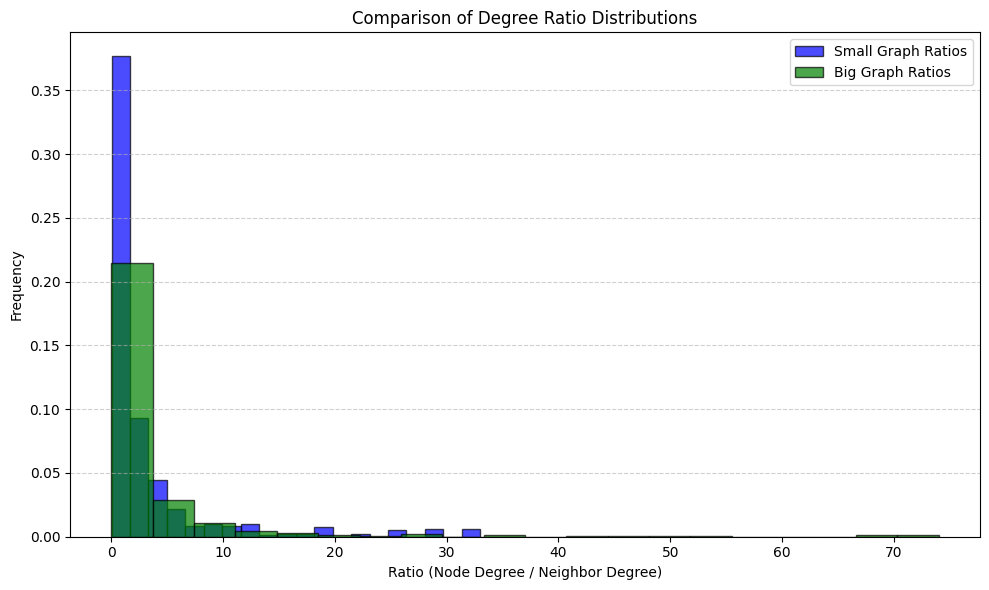

In [41]:
big_ratio = calculate_degree_ratios(big_model.G)
small_ratio = calculate_degree_ratios(small_model.G)


# big_ratio = [x for x in big_ratio if x < 1]
# small_ratio = [x for x in small_ratio if x < 1]

# Create a figure and a single subplot for comparison
plt.figure(figsize=(10, 6))

# Plot histograms for both lists on the same axis
# Use different colors and alpha for transparency to see overlaps
if small_ratio:
    plt.hist(small_ratio, bins=20, alpha=0.7, label='Small Graph Ratios', color='blue', edgecolor='black', density = True)
else:
    print("Warning: small_ratio list is empty. Cannot plot its distribution.")

if big_ratio:
    plt.hist(big_ratio, bins=20, alpha=0.7, label='Big Graph Ratios', color='green', edgecolor='black', density = True)
else:
    print("Warning: big_ratio list is empty. Cannot plot its distribution.")


plt.title('Comparison of Degree Ratio Distributions')
plt.xlabel('Ratio (Node Degree / Neighbor Degree)')
plt.ylabel('Frequency')
plt.legend() # Show the legend to distinguish the two histograms
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

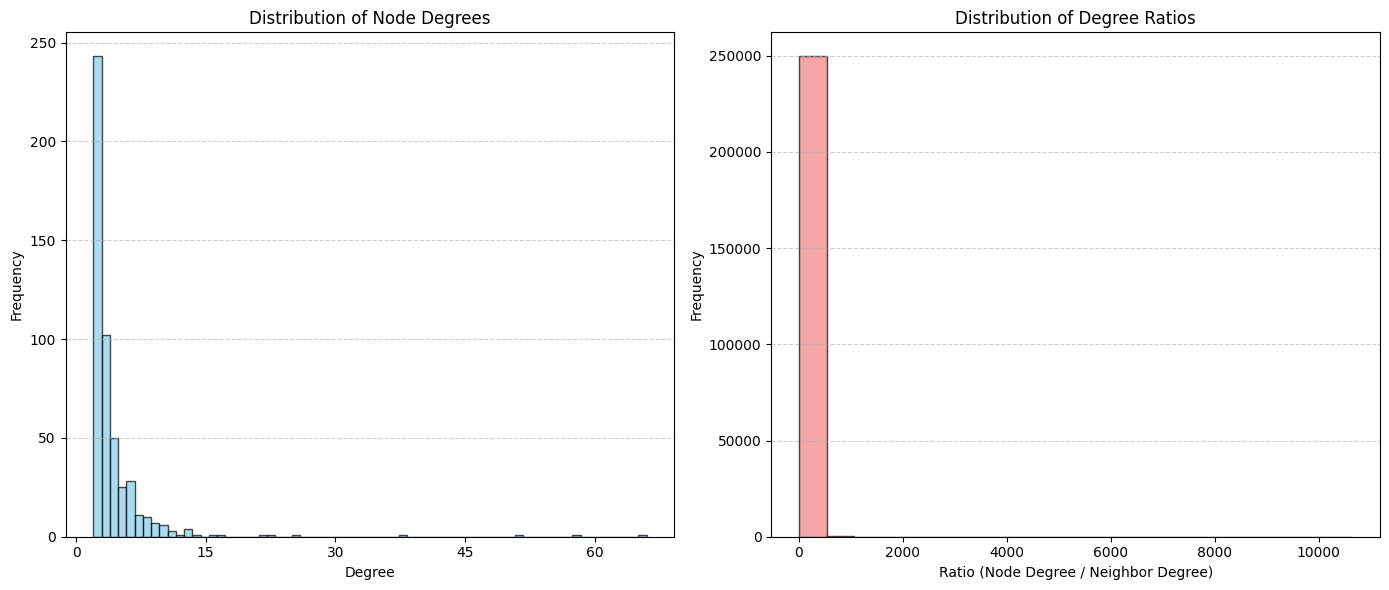

In [47]:
degrees = list(dict(small_model.G.degree).values())
ratios = calculate_all_sigma_ratios(small_model.G, gamma = 3)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Adjusted figsize for better display

# Plotting the distribution of degrees
axes[0].hist(degrees, bins=max(degrees) + 1 if degrees else 10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Node Degrees')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticks(range(max(degrees) + 1) if degrees else []) # Ensure integer ticks if possible
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

# Plotting the distribution of ratios
# Adjust bins for ratios, consider using a dynamic range or fixed number of bins
if ratios:
    num_bins = min(20, int(len(ratios)**(1/3) * 2)) # Simple heuristic for bin count
    axes[1].hist(ratios, bins=num_bins, color='lightcoral', edgecolor='black', alpha=0.7)
else:
    # If ratios list is empty, just show an empty plot for this subplot
    axes[1].text(0.5, 0.5, "No ratios to display", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

axes[1].set_title('Distribution of Degree Ratios')
axes[1].set_xlabel('Ratio (Node Degree / Neighbor Degree)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

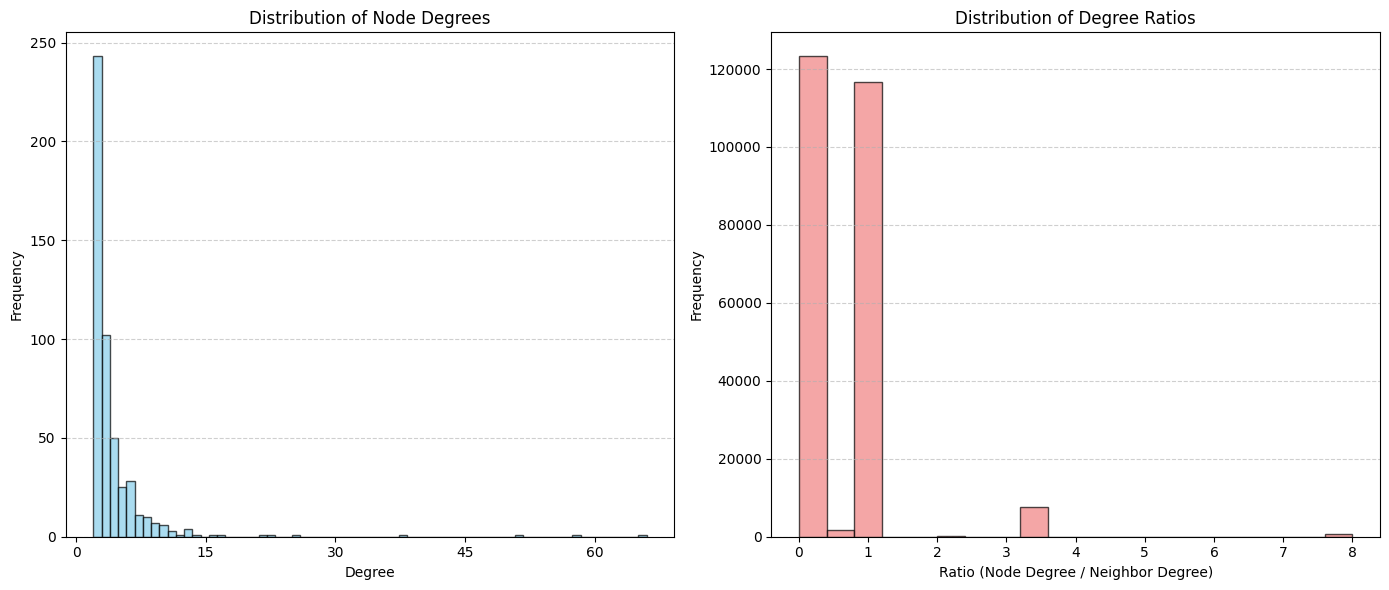

In [53]:
degrees = list(dict(small_model.G.degree).values())
ratios = calculate_all_sigma_ratios(small_model.G, gamma = -3)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Adjusted figsize for better display

# Plotting the distribution of degrees
axes[0].hist(degrees, bins=max(degrees) + 1 if degrees else 10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Node Degrees')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticks(range(max(degrees) + 1) if degrees else []) # Ensure integer ticks if possible
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

# Plotting the distribution of ratios
# Adjust bins for ratios, consider using a dynamic range or fixed number of bins
if ratios:
    num_bins = min(20, int(len(ratios)**(1/3) * 2)) # Simple heuristic for bin count
    axes[1].hist(ratios, bins=num_bins, color='lightcoral', edgecolor='black', alpha=0.7)
else:
    # If ratios list is empty, just show an empty plot for this subplot
    axes[1].text(0.5, 0.5, "No ratios to display", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

axes[1].set_title('Distribution of Degree Ratios')
axes[1].set_xlabel('Ratio (Node Degree / Neighbor Degree)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

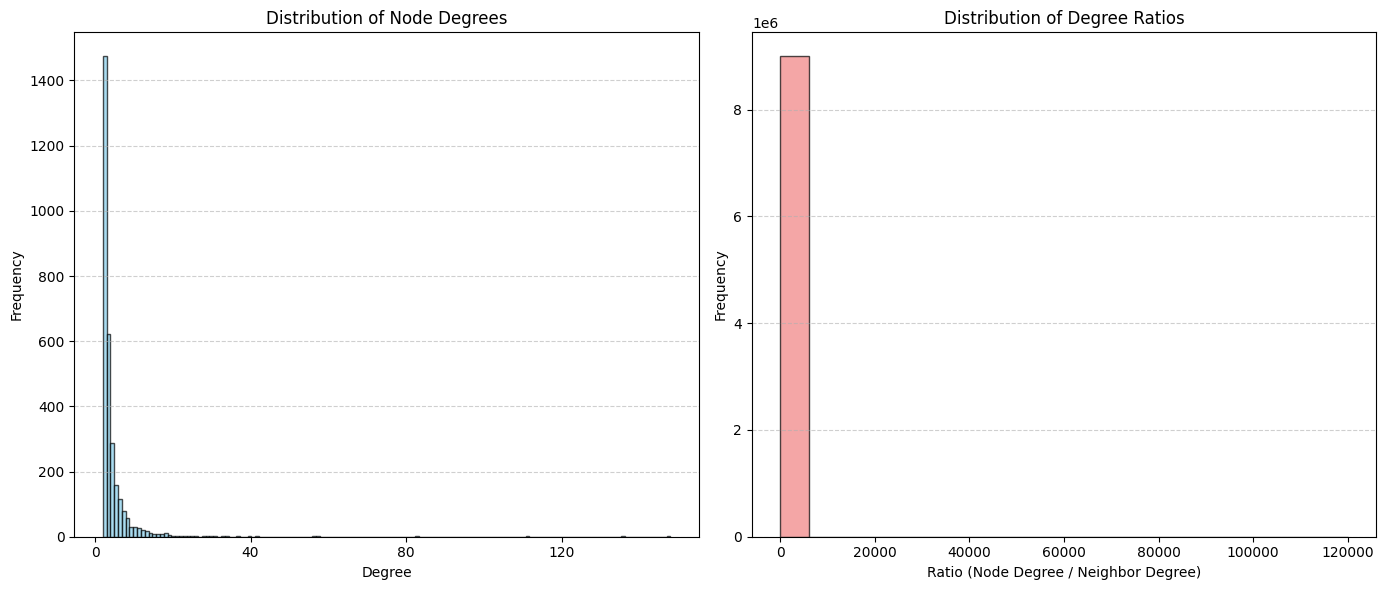

In [49]:
degrees = list(dict(big_model.G.degree).values())
ratios = calculate_all_sigma_ratios(big_model.G, gamma = 3)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Adjusted figsize for better display

# Plotting the distribution of degrees
axes[0].hist(degrees, bins=max(degrees) + 1 if degrees else 10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Node Degrees')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticks(range(max(degrees) + 1) if degrees else []) # Ensure integer ticks if possible
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

# Plotting the distribution of ratios
# Adjust bins for ratios, consider using a dynamic range or fixed number of bins
if ratios:
    num_bins = min(20, int(len(ratios)**(1/3) * 2)) # Simple heuristic for bin count
    axes[1].hist(ratios, bins=num_bins, color='lightcoral', edgecolor='black', alpha=0.7)
else:
    # If ratios list is empty, just show an empty plot for this subplot
    axes[1].text(0.5, 0.5, "No ratios to display", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

axes[1].set_title('Distribution of Degree Ratios')
axes[1].set_xlabel('Ratio (Node Degree / Neighbor Degree)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

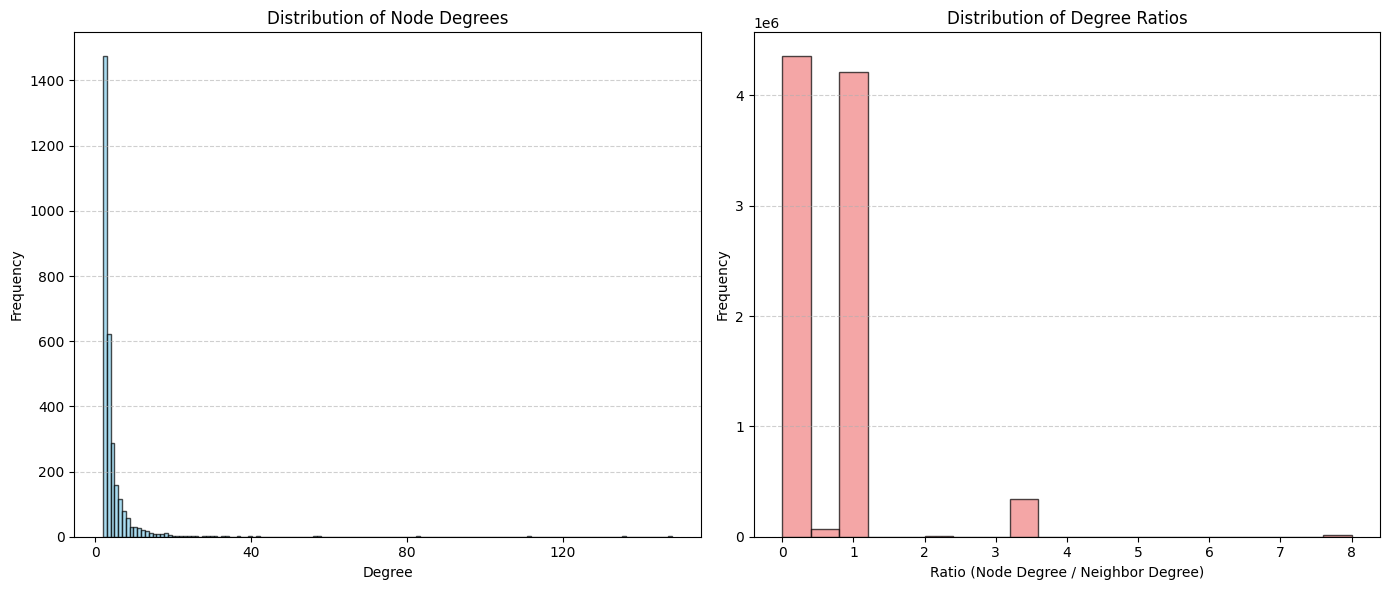

In [52]:
degrees = list(dict(big_model.G.degree).values())
ratios = calculate_all_sigma_ratios(big_model.G, gamma = -3)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Adjusted figsize for better display

# Plotting the distribution of degrees
axes[0].hist(degrees, bins=max(degrees) + 1 if degrees else 10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Node Degrees')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticks(range(max(degrees) + 1) if degrees else []) # Ensure integer ticks if possible
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

# Plotting the distribution of ratios
# Adjust bins for ratios, consider using a dynamic range or fixed number of bins
if ratios:
    num_bins = min(20, int(len(ratios)**(1/3) * 2)) # Simple heuristic for bin count
    axes[1].hist(ratios, bins=num_bins, color='lightcoral', edgecolor='black', alpha=0.7)
else:
    # If ratios list is empty, just show an empty plot for this subplot
    axes[1].text(0.5, 0.5, "No ratios to display", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

axes[1].set_title('Distribution of Degree Ratios')
axes[1].set_xlabel('Ratio (Node Degree / Neighbor Degree)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

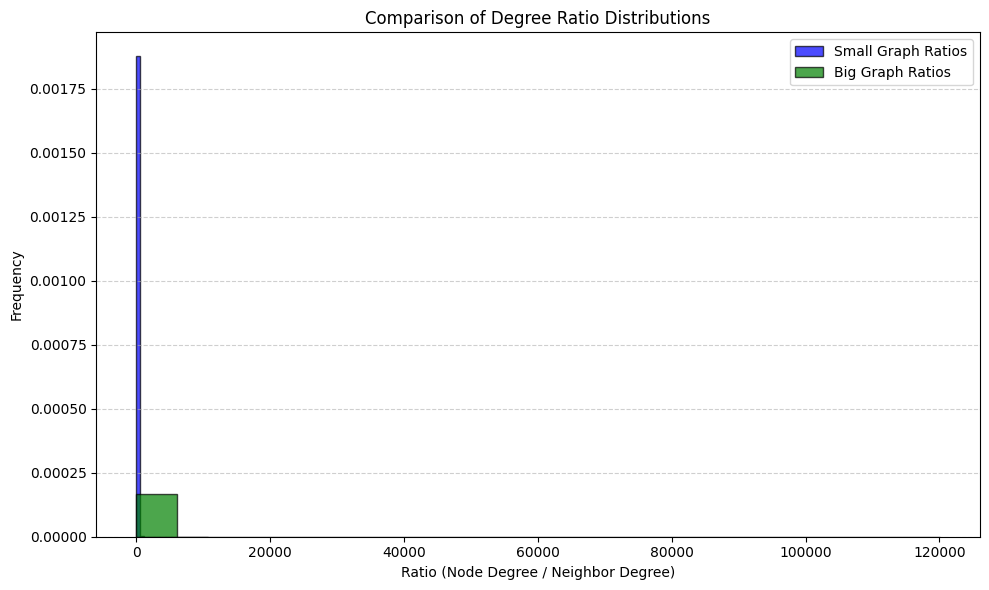

In [50]:
big_ratio = calculate_all_sigma_ratios(big_model.G, gamma = 3)
small_ratio = calculate_all_sigma_ratios(small_model.G, gamma = 3)


# big_ratio = [x for x in big_ratio if x < 1]
# small_ratio = [x for x in small_ratio if x < 1]

# Create a figure and a single subplot for comparison
plt.figure(figsize=(10, 6))

# Plot histograms for both lists on the same axis
# Use different colors and alpha for transparency to see overlaps
if small_ratio:
    plt.hist(small_ratio, bins=20, alpha=0.7, label='Small Graph Ratios', color='blue', edgecolor='black', density = True)
else:
    print("Warning: small_ratio list is empty. Cannot plot its distribution.")

if big_ratio:
    plt.hist(big_ratio, bins=20, alpha=0.7, label='Big Graph Ratios', color='green', edgecolor='black', density = True)
else:
    print("Warning: big_ratio list is empty. Cannot plot its distribution.")


plt.title('Comparison of Degree Ratio Distributions')
plt.xlabel('Ratio (Node Degree / Neighbor Degree)')
plt.ylabel('Frequency')
plt.legend() # Show the legend to distinguish the two histograms
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

In [55]:
len(big_model.G.edges)

5996

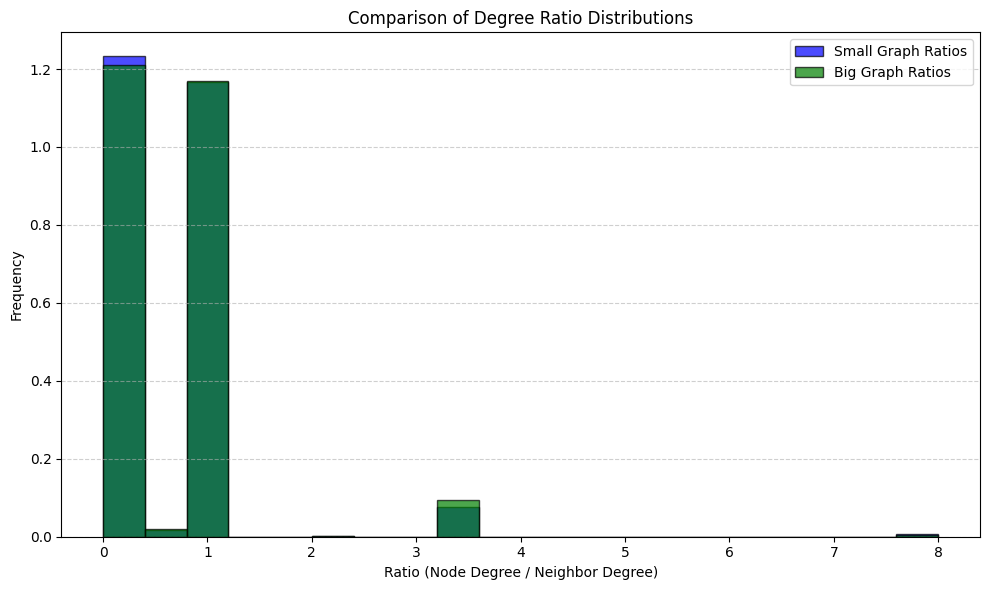

In [51]:
big_ratio = calculate_all_sigma_ratios(big_model.G, gamma = -3)
small_ratio = calculate_all_sigma_ratios(small_model.G, gamma = -3)


# big_ratio = [x for x in big_ratio if x < 1]
# small_ratio = [x for x in small_ratio if x < 1]

# Create a figure and a single subplot for comparison
plt.figure(figsize=(10, 6))

# Plot histograms for both lists on the same axis
# Use different colors and alpha for transparency to see overlaps
if small_ratio:
    plt.hist(small_ratio, bins=20, alpha=0.7, label='Small Graph Ratios', color='blue', edgecolor='black', density = True)
else:
    print("Warning: small_ratio list is empty. Cannot plot its distribution.")

if big_ratio:
    plt.hist(big_ratio, bins=20, alpha=0.7, label='Big Graph Ratios', color='green', edgecolor='black', density = True)
else:
    print("Warning: big_ratio list is empty. Cannot plot its distribution.")


plt.title('Comparison of Degree Ratio Distributions')
plt.xlabel('Ratio (Node Degree / Neighbor Degree)')
plt.ylabel('Frequency')
plt.legend() # Show the legend to distinguish the two histograms
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

In [4]:
params = parse_experiment_params("new_test_params.json")
results = get_experiment_mean_data(params, "results/test3/")

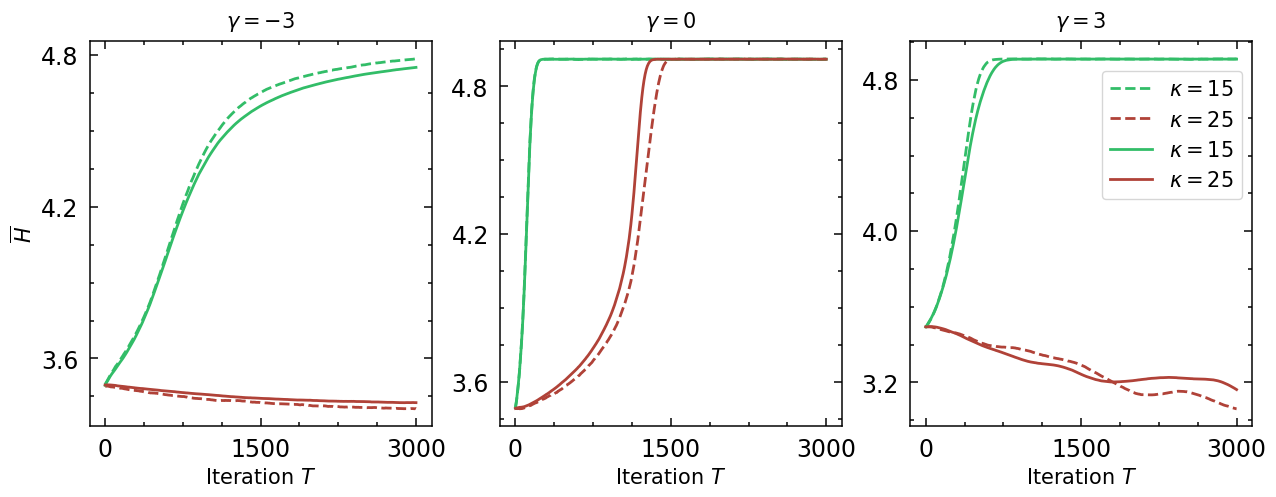

In [5]:
# parameters

nrows = 1
ncols = 3

titles = [rf"$\gamma = {k}$" for k in [-3, 0, 3]]
title_size = 15
single_ylabel = True
position_ylabel = "left"
ylabel = r"$\overline{H}$"
ylabel_fontsize = 15
xlabel_bottom_only = True
xlabel = r"Iteration $T$"
xlabel_fontsize = 15
axis_width = 1.08
tick_pad = 8
tick_label_size = 17
num_x_ticks = 3
num_y_ticks= 3


fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 5*nrows))

fig, axs = classical_structure(
    fig,
    axs,
    axis_width,
    tick_pad,
    tick_label_size,
    num_x_ticks,
    num_y_ticks
)

# Text
fig, axs = format_text(
    fig,
    axs,
    titles,
    title_size,
    single_ylabel,
    position_ylabel,
    ylabel,
    ylabel_fontsize,
    xlabel_bottom_only,
    xlabel,
    xlabel_fontsize
)

# plot
line_width = 2

measure = 'entropy'

kappa_color = {
    0: "#2e2b28",
    15: "#32BD68",
    25: "#b04238"
}

params_ = [x for x in params if x["network_size"] == 500]

X = np.arange(1, 3000 + 1)

selected_params = [x for x in params_ if x['gamma'] == -3]
for p in selected_params:
    axs[0].plot(X, results[make_tuple(p)][measure], c = kappa_color[p['kappa']], linewidth = line_width, linestyle = '--')

X = np.arange(1, 3000 + 1)

selected_params = [x for x in params_ if x['gamma'] == 0]
for p in selected_params:
    axs[1].plot(X, results[make_tuple(p)][measure], c = kappa_color[p['kappa']], linewidth = line_width, linestyle = '--')

X = np.arange(1, 3000 + 1)

selected_params = [x for x in params_ if x['gamma'] == 3]
for p in selected_params:
    axs[2].plot(X, results[make_tuple(p)][measure], c = kappa_color[p['kappa']], linewidth = line_width, label = rf"$\kappa = {p['kappa']}$", linestyle = '--')


params_ = [x for x in params if x["network_size"] == 3000]

X = np.arange(1, 3000 + 1)

selected_params = [x for x in params_ if x['gamma'] == -3]
for p in selected_params:
    axs[0].plot(X, results[make_tuple(p)][measure], c = kappa_color[p['kappa']], linewidth = line_width)

X = np.arange(1, 3000 + 1)

selected_params = [x for x in params_ if x['gamma'] == 0]
for p in selected_params:
    axs[1].plot(X, results[make_tuple(p)][measure], c = kappa_color[p['kappa']], linewidth = line_width)

X = np.arange(1, 3000 + 1)

selected_params = [x for x in params_ if x['gamma'] == 3]
for p in selected_params:
    axs[2].plot(X, results[make_tuple(p)][measure], c = kappa_color[p['kappa']], linewidth = line_width, label = rf"$\kappa = {p['kappa']}$")

axs[2].legend(loc = 'upper right', fontsize = 15, bbox_to_anchor = (1, 0.95))

fig.savefig("temp.png")

In [14]:
params = parse_experiment_params("test_params.json")
results = get_experiment_mean_data(params, "results/test2/")

IndexError: index 1 is out of bounds for axis 0 with size 1

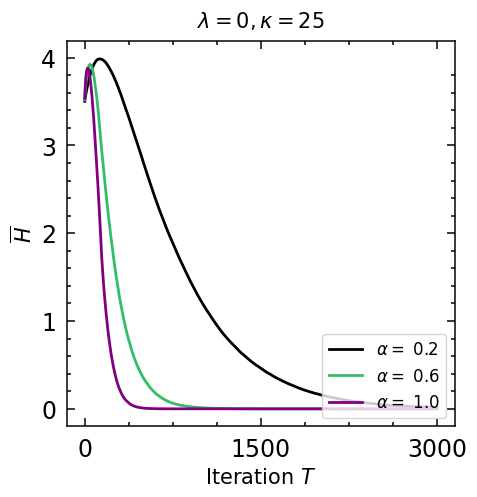

In [19]:
# parameters

nrows = 1
ncols = 1

titles = [
    r"$\lambda = 0, \kappa = 25$",
    r"$\lambda = 0, \kappa = 25$"
]
title_size = 15
single_ylabel = True
position_ylabel = "left"
ylabel = r"$\overline{H}$"
ylabel_fontsize = 15
xlabel_bottom_only = True
xlabel = r"Iteration $T$"
xlabel_fontsize = 15
axis_width = 1.08
tick_pad = 8
tick_label_size = 17
num_x_ticks = 3
num_y_ticks= 5


fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 5*nrows))

fig, axs = classical_structure(
    fig,
    axs,
    axis_width,
    tick_pad,
    tick_label_size,
    num_x_ticks,
    num_y_ticks
)

# Text
fig, axs = format_text(
    fig,
    axs,
    titles,
    title_size,
    single_ylabel,
    position_ylabel,
    ylabel,
    ylabel_fontsize,
    xlabel_bottom_only,
    xlabel,
    xlabel_fontsize
)

# plot
line_width = 2

alpha_omega_color =  {
    1.0: "purple",
    0.6: "#32BD68",
    0.2: "k",
}

X = np.arange(1, 3000 + 1)

for p in params:
    axs[0].plot(
        X,
        results[make_tuple(p, True)]['entropy'],
        c = alpha_omega_color[p['alpha']],
        linewidth = line_width,
        label = rf'$\alpha = $ {p["alpha"]}'
    )

axs[0].legend(loc = 'lower right', fontsize = 12)

fig.subplots_adjust(wspace = 0.3)
axs[1].set_ylabel(r"$\overline{\pi}$")